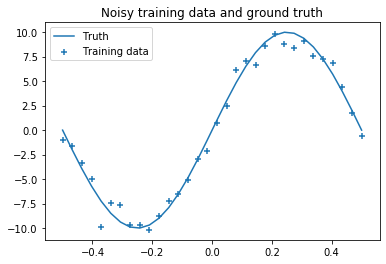

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 32
noise = 1.0

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend();

In [3]:
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer

import tensorflow as tf
import tensorflow_probability as tfp

def mixture_prior_params(sigma_1, sigma_2, pi, return_sigma=False):
    params = K.variable([sigma_1, sigma_2, pi], name='mixture_prior_params')
    sigma = np.sqrt(pi * sigma_1 ** 2 + (1 - pi) * sigma_2 ** 2)
    return params, sigma

def log_mixture_prior_prob(w):
    comp_1_dist = tfp.distributions.Normal(0.0, prior_params[0])
    comp_2_dist = tfp.distributions.Normal(0.0, prior_params[1])
    comp_1_weight = prior_params[2]    
    return K.log(comp_1_weight * comp_1_dist.prob(w) + (1 - comp_1_weight) * comp_2_dist.prob(w))    

# Mixture prior parameters shared across DenseVariational layer instances
prior_params, prior_sigma = mixture_prior_params(sigma_1=1.0, sigma_2=0.1, pi=0.2)

class DenseVariational(Layer):
    def __init__(self, output_dim, kl_loss_weight, activation=None, **kwargs):
        self.output_dim = output_dim
        self.kl_loss_weight = kl_loss_weight
        self.activation = activations.get(activation)
        super().__init__(**kwargs)

    def build(self, input_shape):  
        self._trainable_weights.append(prior_params) 

        self.kernel_mu = self.add_weight(name='kernel_mu', 
                                         shape=(input_shape[1], self.output_dim),
                                         initializer=initializers.normal(stddev=prior_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu', 
                                       shape=(self.output_dim,),
                                       initializer=initializers.normal(stddev=prior_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho', 
                                          shape=(input_shape[1], self.output_dim),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho', 
                                        shape=(self.output_dim,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, x):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)
                
        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) + 
                      self.kl_loss(bias, self.bias_mu, bias_sigma))
        
        return self.activation(K.dot(x, kernel) + bias)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return kl_loss_weight * K.sum(variational_dist.log_prob(w) - log_mixture_prior_prob(w))

In [4]:
from keras.layers import Input
from keras.models import Model

batch_size = train_size
num_batches = train_size / batch_size
kl_loss_weight = 1.0 / num_batches

x_in = Input(shape=(1,))
x = DenseVariational(20, kl_loss_weight=kl_loss_weight, activation='relu')(x_in)
x = DenseVariational(20, kl_loss_weight=kl_loss_weight, activation='relu')(x)
x = DenseVariational(1, kl_loss_weight=kl_loss_weight)(x)

model = Model(x_in, x)

In [5]:
from keras import callbacks, optimizers

def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

model.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=0.03), metrics=['mse'])
model.fit(X, y, batch_size=batch_size, epochs=1500, verbose=0);

100%|██████████| 500/500 [00:05<00:00, 89.06it/s] 


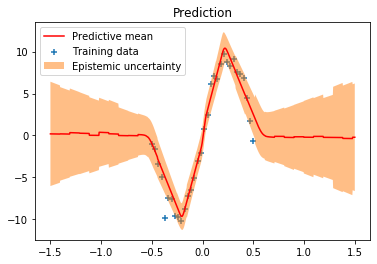

In [16]:
import tqdm

X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
y_pred_list = []

for i in tqdm.tqdm(range(500)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(X, y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.legend();

In [13]:
def neg_log_likelihood_weighted(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-tf.math.multiply(dist.log_prob(y_obs), weights))


exp_dist = tfp.distributions.Exponential(rate = 1)
weights = exp_dist.sample(tf.shape(y))

In [15]:
model.compile(loss=neg_log_likelihood_weighted, optimizer=optimizers.Adam(lr=0.03), metrics=['mse'])
model.fit(X, y, batch_size=batch_size, epochs=1500, verbose=0);